In [1]:
import numpy as np
import os

import datetime
import os
import abc
from sys import getsizeof
from PIL import Image
from skimage.transform import resize
import imageio
import cv2
import matplotlib.pyplot as plt

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 20 #experiment with the batch size
project_folder='/datasets/Project_data'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [6]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [7]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

2024-01-03 04:35:27.089250: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-03 04:35:27.089311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [7]:

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

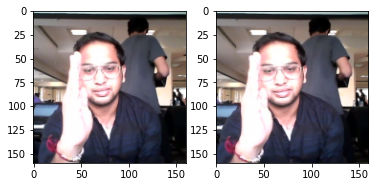

In [9]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [10]:

conv_3d1.train_model(conv_3d1_model)

/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
2024-01-02 10:36:48.675259: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.6450 - categorical_accuracy: 0.4087 
Epoch 00001: saving model to model_init_2024-01-0210_36_31.528822/model-00001-1.64504-0.40875-3.16129-0.16000.h5
17/17 [==============================] - 290s 18s/step - loss: 1.6450 - categorical_accuracy: 0.4087 - val_loss: 3.1613 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [11]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.3541 - categorical_accuracy: 0.5023
Epoch 00001: saving model to model_init_2024-01-0210_41_35.801377/model-00001-1.35408-0.50226-2.27320-0.20000.h5
23/23 [==============================] - 155s 7s/step - loss: 1.3541 - categorical_accuracy: 0.5023 - val_loss: 2.2732 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 0.8833 - categorical_accuracy: 0.6486
Epoch 00002: saving model to model_init_2024-01-0210_41_35.801377/model-00002-0.88331-0.64857-3.95042-0.20000.h5
23/23 [==============================] - 139s 6s/step - loss: 0.8833 - categorical_accuracy: 0.6486 - val_loss: 3.9504 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/3
22/23 [===========================>..] - ETA: 5s - loss: 0.5849 - categorical_accuracy: 0.7818 
Epoch 00003: saving model to model_init_2024-01-0210_41_35.801377/model-00003-0.58262-0.78281-6.00910-0.21000.h5
23/23 [====

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6773 - categorical_accuracy: 0.3710
Epoch 00001: saving model to model_init_2024-01-0210_48_43.651458/model-00001-1.67730-0.37104-1.79979-0.22000.h5
23/23 [==============================] - 241s 11s/step - loss: 1.6773 - categorical_accuracy: 0.3710 - val_loss: 1.7998 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.1424 - categorical_accuracy: 0.5505
Epoch 00002: saving model to model_init_2024-01-0210_48_43.651458/model-00002-1.14243-0.55053-2.61934-0.23000.h5
23/23 [==============================] - 248s 11s/step - loss: 1.1424 - categorical_accuracy: 0.5505 - val_loss: 2.6193 - val_categorical_accuracy: 0.2300 - lr: 0.0010


In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.6029 - categorical_accuracy: 0.4359 
Epoch 00001: saving model to model_init_2024-01-0210_57_00.348821/model-00001-1.60293-0.43590-1.86777-0.16000.h5
12/12 [==============================] - 219s 20s/step - loss: 1.6029 - categorical_accuracy: 0.4359 - val_loss: 1.8678 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.1056 - categorical_accuracy: 0.5852 
Epoch 00002: saving model to model_init_2024-01-0210_57_00.348821/model-00002-1.10558-0.58522-2.80637-0.15000.h5
12/12 [==============================] - 207s 19s/step - loss: 1.1056 - categorical_accuracy: 0.5852 - val_loss: 2.8064 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)


Total Params: 687813


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.4757 - categorical_accuracy: 0.4495
Epoch 00001: saving model to model_init_2024-01-0211_04_21.956092/model-00001-1.47572-0.44947-1.60291-0.19000.h5
12/12 [==============================] - 109s 10s/step - loss: 1.4757 - categorical_accuracy: 0.4495 - val_loss: 1.6029 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.1483 - categorical_accuracy: 0.5535
Epoch 00002: saving model to model_init_2024-01-0211_04_21.956092/model-00002-1.14834-0.55354-1.75248-0.25000.h5
12/12 [==============================] - 113s 10s/step - loss: 1.1483 - categorical_accuracy: 0.5535 - val_loss: 1.7525 - val_categorical_accuracy: 0.2500 - lr: 0.0010


In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.6396 - categorical_accuracy: 0.4072 
Epoch 00001: saving model to model_init_2024-01-0211_08_11.980223/model-00001-1.63960-0.40724-1.68958-0.16000.h5
9/9 [==============================] - 121s 15s/step - loss: 1.6396 - categorical_accuracy: 0.4072 - val_loss: 1.6896 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 1.0623 - categorical_accuracy: 0.6018 
Epoch 00002: saving model to model_init_2024-01-0211_08_11.980223/model-00002-1.06232-0.60181-2.31829-0.17000.h5
9/9 [==============================] - 125s 16s/step - loss: 1.0623 - categorical_accuracy: 0.6018 - val_loss: 2.3183 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.4860 - categorical_accuracy: 0.4103
Epoch 00001: saving model to model_init_2024-01-0211_12_27.878290/model-00001-1.48599-0.41026-6.87263-0.20000.h5
45/45 [==============================] - 286s 6s/step - loss: 1.4860 - categorical_accuracy: 0.4103 - val_loss: 6.8726 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9327 - categorical_accuracy: 0.6516
Epoch 00002: saving model to model_init_2024-01-0211_12_27.878290/model-00002-0.93265-0.65158-10.50255-0.23000.h5
45/45 [==============================] - 254s 6s/step - loss: 0.9327 - categorical_accuracy: 0.6516 - val_loss: 10.5025 - val_categorical_accuracy: 0.2300 - lr: 0.0010


In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.4726 - categorical_accuracy: 0.4525
Epoch 00001: saving model to model_init_2024-01-0211_21_33.012702/model-00001-1.47259-0.45249-3.37671-0.21000.h5
45/45 [==============================] - 132s 3s/step - loss: 1.4726 - categorical_accuracy: 0.4525 - val_loss: 3.3767 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.8593 - categorical_accuracy: 0.6621
Epoch 00002: saving model to model_init_2024-01-0211_21_33.012702/model-00002-0.85930-0.66214-5.76670-0.23000.h5
45/45 [==============================] - 130s 3s/step - loss: 0.8593 - categorical_accuracy: 0.6621 - val_loss: 5.7667 - val_categorical_accuracy: 0.2300 - lr: 0.0010


In [19]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5656 - categorical_accuracy: 0.4148
Epoch 00001: saving model to model_init_2024-01-0211_25_57.744736/model-00001-1.56558-0.41478-4.09292-0.16000.h5
45/45 [==============================] - 97s 2s/step - loss: 1.5656 - categorical_accuracy: 0.4148 - val_loss: 4.0929 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9089 - categorical_accuracy: 0.6365
Epoch 00002: saving model to model_init_2024-01-0211_25_57.744736/model-00002-0.90892-0.63650-5.03713-0.24000.h5
45/45 [==============================] - 95s 2s/step - loss: 0.9089 - categorical_accuracy: 0.6365 - val_loss: 5.0371 - val_categorical_accuracy: 0.2400 - lr: 0.0010


In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6380 - categorical_accuracy: 0.4057
Epoch 00001: saving model to model_init_2024-01-0211_29_10.730507/model-00001-1.63804-0.40573-4.64048-0.16000.h5
67/67 [==============================] - 97s 1s/step - loss: 1.6380 - categorical_accuracy: 0.4057 - val_loss: 4.6405 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1122 - categorical_accuracy: 0.5897
Epoch 00002: saving model to model_init_2024-01-0211_29_10.730507/model-00002-1.11218-0.58974-9.27172-0.16000.h5
67/67 [==============================] - 103s 2s/step - loss: 1.1122 - categorical_accuracy: 0.5897 - val_loss: 9.2717 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [21]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5241 - categorical_accuracy: 0.4465
Epoch 00001: saving model to model_init_2024-01-0211_32_32.950229/model-00001-1.52413-0.44646-2.66208-0.16000.h5
67/67 [==============================] - 229s 3s/step - loss: 1.5241 - categorical_accuracy: 0.4465 - val_loss: 2.6621 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2924 - categorical_accuracy: 0.4902
Epoch 00002: saving model to model_init_2024-01-0211_32_32.950229/model-00002-1.29238-0.49020-3.67617-0.22000.h5
67/67 [==============================] - 230s 3s/step - loss: 1.2924 - categorical_accuracy: 0.4902 - val_loss: 3.6762 - val_categorical_accuracy: 0.2200 - lr: 0.0010


In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.4986 - categorical_accuracy: 0.4721
Epoch 00001: saving model to model_init_2024-01-0211_40_14.483383/model-00001-1.49864-0.47210-3.00185-0.31000.h5
67/67 [==============================] - 117s 2s/step - loss: 1.4986 - categorical_accuracy: 0.4721 - val_loss: 3.0019 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 0.9114 - categorical_accuracy: 0.6410
Epoch 00002: saving model to model_init_2024-01-0211_40_14.483383/model-00002-0.91141-0.64103-5.74297-0.21000.h5
67/67 [==============================] - 105s 2s/step - loss: 0.9114 - categorical_accuracy: 0.6410 - val_loss: 5.7430 - val_categorical_accuracy: 0.2100 - lr: 0.0010


## Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [23]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_72 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_49 (Activation)  (None, 10, 80, 80, 32)  

In [25]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5390 - categorical_accuracy: 0.4404
Epoch 00001: saving model to model_init_2024-01-0211_43_57.978118/model-00001-1.53902-0.44042-1.69067-0.27000.h5
17/17 [==============================] - 144s 9s/step - loss: 1.5390 - categorical_accuracy: 0.4404 - val_loss: 1.6907 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9645 - categorical_accuracy: 0.6259
Epoch 00002: saving model to model_init_2024-01-0211_43_57.978118/model-00002-0.96448-0.62594-2.70608-0.18000.h5
17/17 [==============================] - 143s 9s/step - loss: 0.9645 - categorical_accuracy: 0.6259 - val_loss: 2.7061 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6289 - categorical_accuracy: 0.7526
Epoch 00003: saving model to model_init_2024-01-0211_43_57.978118/model-00003-0.62892-0.75264-2.97670-0.22000.h5
17/17 [==

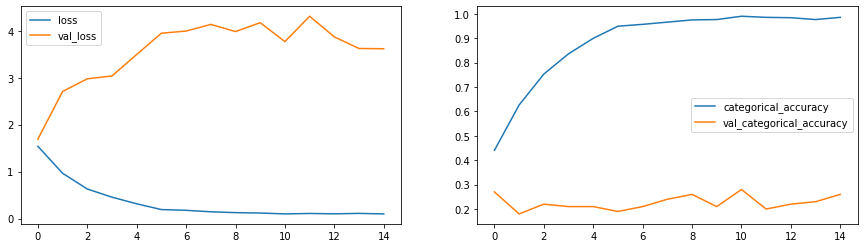

In [26]:

plot(history_model1)

## Model 2


In [27]:
## augment data

conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_78 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_53 (Activation)  (None, 10, 80, 80, 32)  

In [28]:

print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981


/tmp/ipykernel_332/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8318 - categorical_accuracy: 0.4050
Epoch 00001: saving model to model_init_2024-01-0212_19_52.801279/model-00001-1.83184-0.40498-2.14066-0.28000.h5
34/34 [==============================] - 262s 8s/step - loss: 1.8318 - categorical_accuracy: 0.4050 - val_loss: 2.1407 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4008 - categorical_accuracy: 0.5166
Epoch 00002: saving model to model_init_2024-01-0212_19_52.801279/model-00002-1.40085-0.51659-3.74704-0.22000.h5
34/34 [==============================] - 274s 8s/step - loss: 1.4008 - categorical_accuracy: 0.5166 - val_loss: 3.7470 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9919 - categorical_accuracy: 0.6493
Epoch 00003: saving model to model_init_2024-01-0212_19_52.801279/model-00003-0.99195-0.64932-5.77215-0.27000.h5
34/34 [==

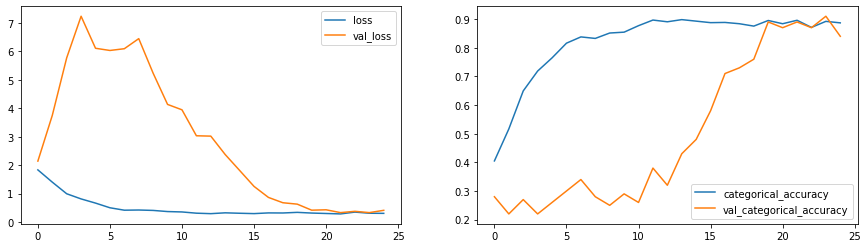

In [29]:
plot(history_model2)

Model 3

In [7]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [8]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

2024-01-02 14:55:00.636285: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-02 14:55:00.636348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5
/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613


/tmp/ipykernel_301/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/30


2024-01-02 14:55:11.077226: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 2.0423 - categorical_accuracy: 0.3514 
Epoch 00001: saving model to model_init_2024-01-0214_55_00.812936/model-00001-2.04235-0.35143-1.87860-0.16000.h5
23/23 [==============================] - 270s 12s/step - loss: 2.0423 - categorical_accuracy: 0.3514 - val_loss: 1.8786 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.3688 - categorical_accuracy: 0.5173 
Epoch 00002: saving model to model_init_2024-01-0214_55_00.812936/model-00002-1.36881-0.51735-2.78605-0.16000.h5
23/23 [==============================] - 240s 11s/step - loss: 1.3688 - categorical_accuracy: 0.5173 - val_loss: 2.7861 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1341 - categorical_accuracy: 0.6033
Epoch 00003: saving model to model_init_2024-01-0214_55_00.812936/model-00003-1.13414-0.60332-3.38167-0.17000.h5
23/23 [=

In [13]:

plot(history_model3)

NameError: name 'history_model3' is not defined

## Model 4

In [8]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_5 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_7 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                      

In [10]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533


/tmp/ipykernel_301/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/30


2024-01-03 04:36:06.482494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.9504 - categorical_accuracy: 0.3710
Epoch 00001: saving model to model_init_2024-01-0304_35_59.559582/model-00001-1.95036-0.37104-2.02619-0.21000.h5
34/34 [==============================] - 204s 6s/step - loss: 1.9504 - categorical_accuracy: 0.3710 - val_loss: 2.0262 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5217 - categorical_accuracy: 0.4804
Epoch 00002: saving model to model_init_2024-01-0304_35_59.559582/model-00002-1.52167-0.48039-2.50353-0.35000.h5
34/34 [==============================] - 196s 6s/step - loss: 1.5217 - categorical_accuracy: 0.4804 - val_loss: 2.5035 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2636 - categorical_accuracy: 0.5468
Epoch 00003: saving model to model_init_2024-01-0304_35_59.559582/model-00003-1.26362-0.54676-3.14310-0.28000.h5
34/34 [=============

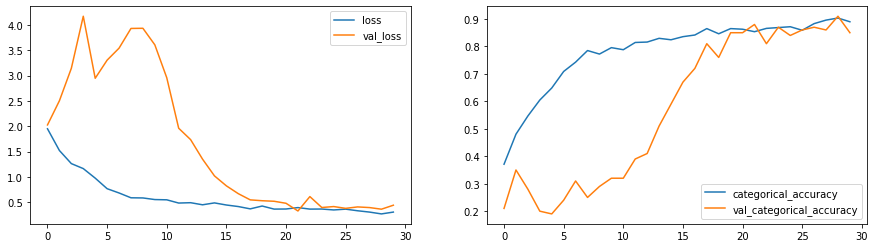

In [19]:

plot(history_model4)

Model 5

In [14]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_13 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_17 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [16]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533


/tmp/ipykernel_301/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.7668 - categorical_accuracy: 0.4027
Epoch 00001: saving model to model_init_2024-01-0306_24_43.812973/model-00001-1.76684-0.40271-3.33756-0.16000.h5
34/34 [==============================] - 209s 6s/step - loss: 1.7668 - categorical_accuracy: 0.4027 - val_loss: 3.3376 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.2856 - categorical_accuracy: 0.5256
Epoch 00002: saving model to model_init_2024-01-0306_24_43.812973/model-00002-1.28559-0.52564-3.29824-0.18000.h5
34/34 [==============================] - 202s 6s/step - loss: 1.2856 - categorical_accuracy: 0.5256 - val_loss: 3.2982 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.0798 - categorical_accuracy: 0.5807
Epoch 00003: saving model to model_init_2024-01-0306_24_43.812973/model-00003-1.07981-0.58069-4.62254-0.22000.h5
34/34 [==

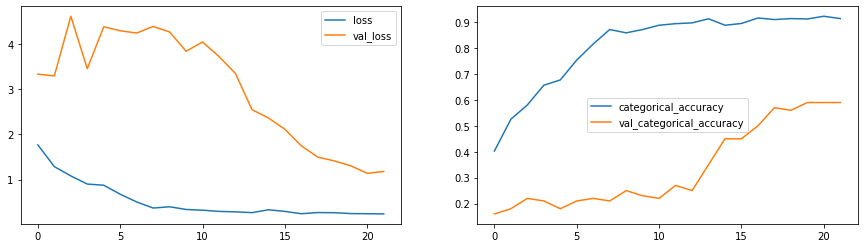

In [20]:

plot(history_model5)

Model 6

In [8]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

2024-01-03 08:52:18.478483: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-03 08:52:18.478545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)   1

In [10]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model6=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445


/tmp/ipykernel_302/2327497117.py:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20


2024-01-03 08:52:34.015322: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.3581 - categorical_accuracy: 0.4397
Epoch 00001: saving model to model_init_2024-01-0308_52_19.877020/model-00001-1.35808-0.43967-1.76900-0.20000.h5
34/34 [==============================] - 243s 7s/step - loss: 1.3581 - categorical_accuracy: 0.4397 - val_loss: 1.7690 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9653 - categorical_accuracy: 0.6267
Epoch 00002: saving model to model_init_2024-01-0308_52_19.877020/model-00002-0.96535-0.62670-2.37412-0.14000.h5
34/34 [==============================] - 295s 9s/step - loss: 0.9653 - categorical_accuracy: 0.6267 - val_loss: 2.3741 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8382 - categorical_accuracy: 0.6848
Epoch 00003: saving model to model_init_2024-01-0308_52_19.877020/model-00003-0.83819-0.68477-2.21915-0.15000.h5
34/34 [=============

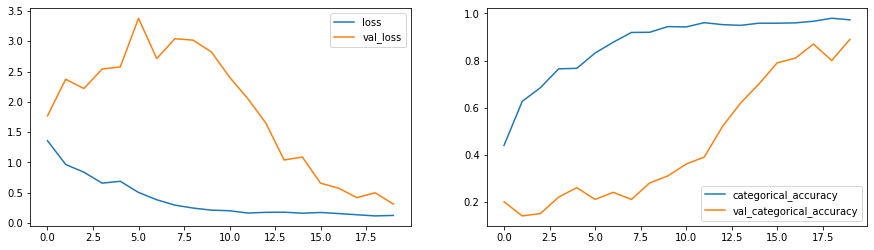

In [ ]:

plot(history_model6)

## Final Modal Details Consolidated



Consolidating the results of all the models created so far. 

Model 1 -  Training Accuracy : 0.98   | Validation Accuracy : 0.26    | Paramaters :  11,17,061

Model 2 -  Training Accuracy : 0.88   | Validation Accuracy : 0.84    | Paramaters :  36,38,981

Model 3 -  Training Accuracy : 0.73   | Validation Accuracy : 0.80    | Paramaters :  17,62,613

Model 4 -  Training Accuracy : 0.88   | Validation Accuracy : 0.85    | Paramaters :  25,56,533

Model 5 -  Training Accuracy : 0.91   | Validation Accuracy : 0.59    | Paramaters :  25,56,533

Model 6 -  Training Accuracy : 0.97   | Validation Accuracy : 0.89    |  Paramaters : 16,57,445

## Conclusion 

We can see that Model 1 was very inaccurate with the lowerst validation accuracy but as the models progressed we did see a good improvement in the accuracy consistantly.
The objective was to pick a model with the least paramaters and still having the highest accuracy and looks like model 6 satisfies both criterias

Model 6 is having the second least number of paramaters (the lowest being Model 1 but is very inaccurate) and has a training accuracy of 97 % and Validation accuracy of 89% which looks to be very good